## Visualization of Tibet dynamic model
### D. Li, 24.1.2022

In [1]:
# initialize and load modules
%matplotlib notebook
from pythonXdmfReader.pythonXdmfReader import*
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pyproj
import scipy.io as sio
from scipy import spatial
from cmcrameri import cm
from scipy.io import netcdf_file as netcdf

import matplotlib 
matplotlib.rc('xtick', labelsize=9) 
matplotlib.rc('ytick', labelsize=9)

print('module loaded')

module loaded


<IPython.core.display.Javascript object>


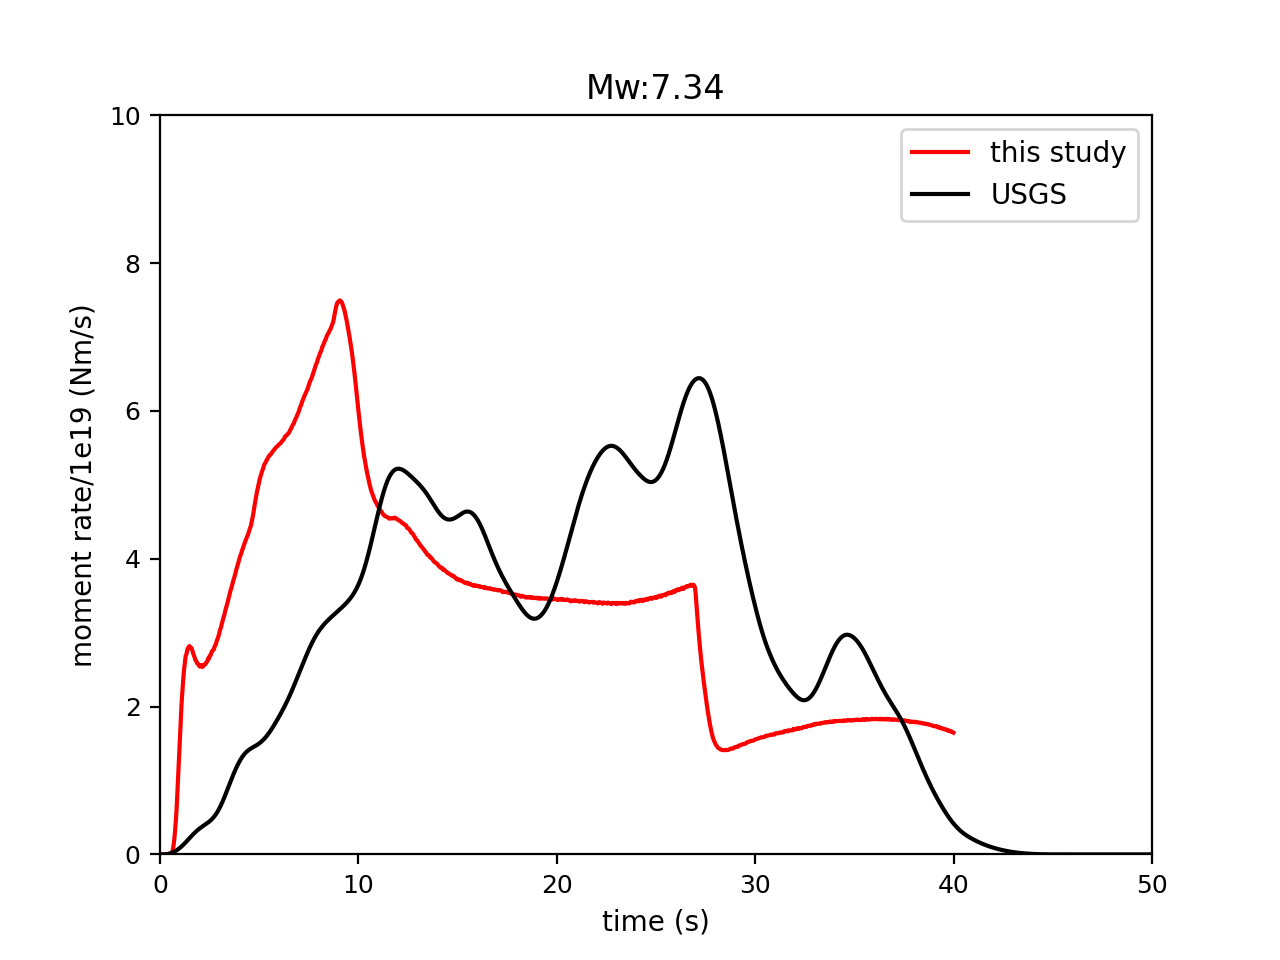

In [2]:
## plot moment rate with time
folder = 'output/'
#modelname = 'data6'
modelname = 'd7'

fin = open(folder+modelname+'-EnF_0t-all.dat','r')
enf = np.loadtxt(fin,comments='#',skiprows=1)

mfile='STF_usgs.txt'
fin2 = open(mfile,'r');
mr = np.loadtxt(fin2);

plt.figure()

#plt.subplot(1,2,1)               
plt.plot(enf[:,0],enf[:,1]*1e7/1e25,'-r')   # from MPa*m**2/s to dyne-cm/s
plt.plot(mr[:,0],mr[:,1]/1e18,'-k')
plt.legend(['this study','USGS'])

plt.xlabel('time (s)')
plt.ylabel('moment rate/1e19 (Nm/s)')
plt.xlim([0,50])
plt.ylim([0,10])


# seismic moment magnitude
moment0 = 0.0
M0 = np.trapz(enf[:,1], x=enf[:,0])

mag  = 2/3*np.log10(M0)-6.07

plt.title('Mw:'+str(round(mag,2)))
plt.savefig(modelname+'-mag.png',dpi=150)


In [10]:
# setup folder and model
folder = '/import/freenas-m-05-seissol/dli/Qinghai/output/'
# model name
modelname = 'c1'
print('model = '+ modelname)

model = c1


<IPython.core.display.Javascript object>


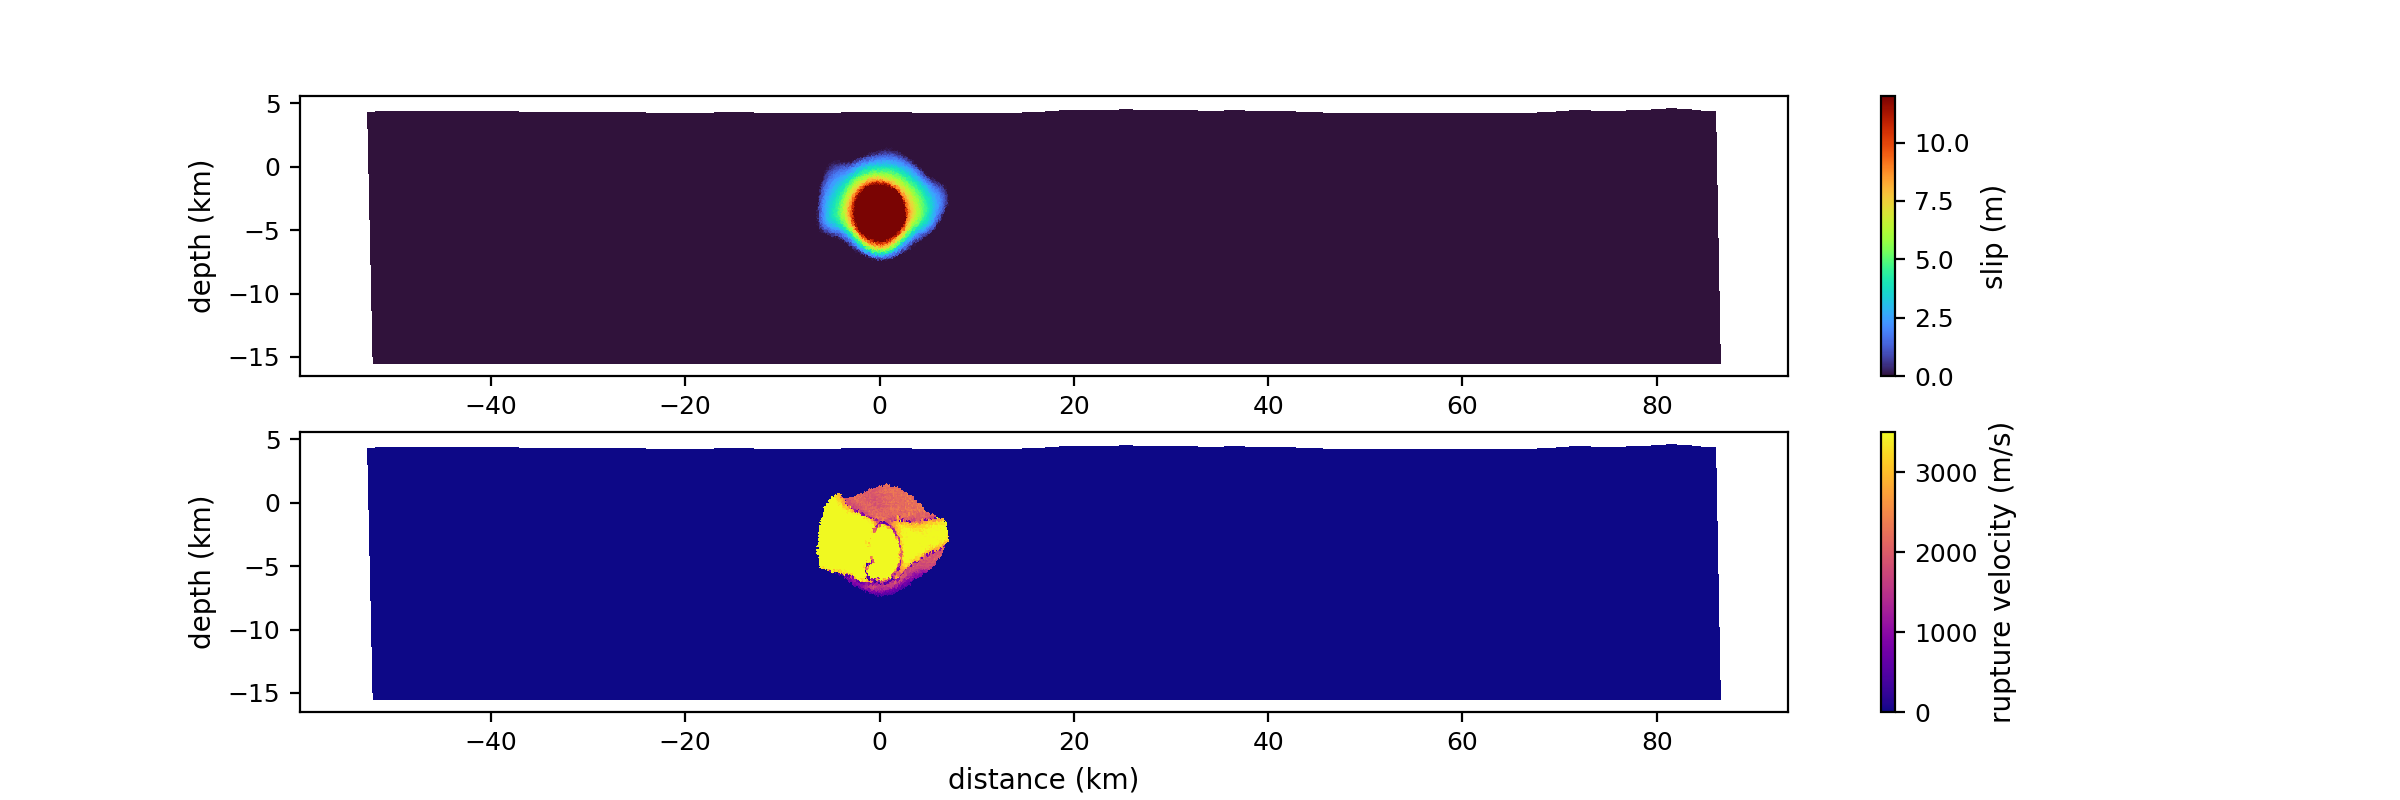

In [14]:
# load data

lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
myproj = pyproj.Proj(proj='lcc', init='EPSG:3415')

xdmfFilename = folder + modelname+'-fault.xdmf'

hypoll = np.loadtxt('hypocenters.dat')

#lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
#myproj = pyproj.Proj(proj='geocent',init='EPSG:5936',ellps='WGS84', datum='WGS84')

ndt = ReadNdt(xdmfFilename)-2
xyz = ReadGeometry(xdmfFilename)
connect = ReadConnect(xdmfFilename)

#ncst = pyproj.transform(lla, myproj, coast['data'][:,0],coast['data'][:,1], radians=False)
#hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)
d = 101.0/180.0*np.pi
triang = tri.Triangulation((xyz[:,0]/1e3-hypoll[0]/1e3)/np.sin(d),xyz[:,2]/1e3,connect)

#%%
asl= LoadData(xdmfFilename,'ASl',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
vr =LoadData(xdmfFilename,'Vr',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
td = LoadData(xdmfFilename,'T_d',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
# srd=LoadData(xdmfFilename,'PSR',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)
#%%

fig=plt.figure(figsize=(12,4.0))


#ax0.set_title('Mapview of Td0')
ax0 = fig.add_subplot(2, 1, 1)
sc = ax0.tripcolor(triang,asl[0],cmap='turbo',vmin=0.0,vmax=12.0)
ax0.set_xlabel('distance (km)')
ax0.set_ylabel('depth (km)')

cl = fig.colorbar(sc,ax=ax0)
cl.set_label('slip (m)')

ax0 = fig.add_subplot(2, 1, 2)
sc = ax0.tripcolor(triang,vr[0],cmap='plasma',vmin=0.0,vmax=3500.0)
ax0.set_xlabel('distance (km)')
ax0.set_ylabel('depth (km)')
cl = fig.colorbar(sc,ax=ax0)
cl.set_label('rupture velocity (m/s)')

outname = modelname+'-slp-vr.png'
plt.savefig(outname,dpi=100,transparent=False)


In [ ]:
## avearging of stress drop
nnd = np.where(asl[0] >1.00)
tde1 = np.mean(np.sum(td[nnd]*cellarea[nnd])/np.sum(cellarea[nnd]))
print(tde1/1e6)

tde2 = np.mean(np.sum(td[nnd]*cellarea[nnd]*asl[0][nnd])/np.sum(cellarea[nnd]*asl[0][nnd]))
print(tde2/1e6)


fig,ax2 = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

sc = ax2.tripcolor(triang,td/1e6,cmap=cm.roma,shading='flat',vmin=-5,vmax=5)
cl = fig.colorbar(sc,ax=ax2,shrink=0.7)
cl.set_label('stress drop(MPa)')

ax2.set(xlim=(-102.5, -99.5),ylim=(16,18.5))
ax2.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
# ax2.contour(X,Y,coslp,levels=[8,16],colors='w')
ax2.set_aspect(1)
ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude')
ax2.xaxis.set_ticks([-102,-101,-100])
ax2.plot(epi[:,0],epi[:,1],'*r',markersize=4.0)

plt.show()
outname = modelname+'-td.png'
plt.savefig(outname,dpi=200,transparent=False)

print(np.max(S))
print(np.min(S))

In [ ]:
# fracture energy / breakdown energy
td_final = LoadData(xdmfFilename,'Td0',connect.shape[0],idt=ndt-1,oneDtMem=True,firstElement=-1)

k = 0.5 * (td0[0]-td_final[0])*0.2/1e6
g_c   = -0.5*0.2*(0.626*pn0[0]-0.546*pn0[0])/1e6
nnk = np.where(k>0.0)

print(np.sum(k[nnk]))

fig,ax2 = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

sc = ax2.tripcolor(triang,k,cmap='magma_r',shading='flat',vmin=0,vmax=0.5)
cl = fig.colorbar(sc,ax=ax2,shrink=0.7)
cl.set_label('fracture energy (1e6 J/m2)')

ax2.set(xlim=(-102.5, -99.5),ylim=(16,18.5))
ax2.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax2.set_aspect(1)
ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude')
ax2.xaxis.set_ticks([-102,-101,-100])

plt.show()
outname = modelname+'-frac.png'
plt.savefig(outname,dpi=200,transparent=False)


In [ ]:
fig,ax2 = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

sc = ax2.tripcolor(triang,S,cmap='PuOr',shading='flat',vmin=-0.5,vmax=0.5)
cl = fig.colorbar(sc,ax=ax2,shrink=0.7)
cl.set_label('S')

ax2.set(xlim=(-102.5, -99.5),ylim=(16,18.5))
ax2.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
# ax2.contour(X,Y,coslp,levels=[8,16],colors='w')
ax2.set_aspect(1)
ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude')
ax2.xaxis.set_ticks([-102,-101,-100])

plt.show()
outname = modelname+'-S.png'
plt.savefig(outname,dpi=200,transparent=False)

print(np.max(S))
print(np.min(S))

In [9]:
## plot slip and rupture speed
# load data for snapshort
srd1= LoadData(xdmfFilename,'SRd',connect.shape[0],idt=8,oneDtMem=True,firstElement=-1)
srd2= LoadData(xdmfFilename,'SRd',connect.shape[0],idt=16,oneDtMem=True,firstElement=-1)
srd3= LoadData(xdmfFilename,'SRd',connect.shape[0],idt=30,oneDtMem=True,firstElement=-1)
srd4 =LoadData(xdmfFilename,'SRd',connect.shape[0],idt=42,oneDtMem=True,firstElement=-1)
srd5 =LoadData(xdmfFilename,'SRd',connect.shape[0],idt=54,oneDtMem=True,firstElement=-1)

# srd5= LoadData(xdmfFilename,'SRd',connect.shape[0],idt=30,oneDtMem=True,firstElement=-1)
# srd6 =LoadData(xdmfFilename,'SRd',connect.shape[0],idt=int(5*ndt/6),oneDtMem=True,firstElement=-1)

<IPython.core.display.Javascript object>


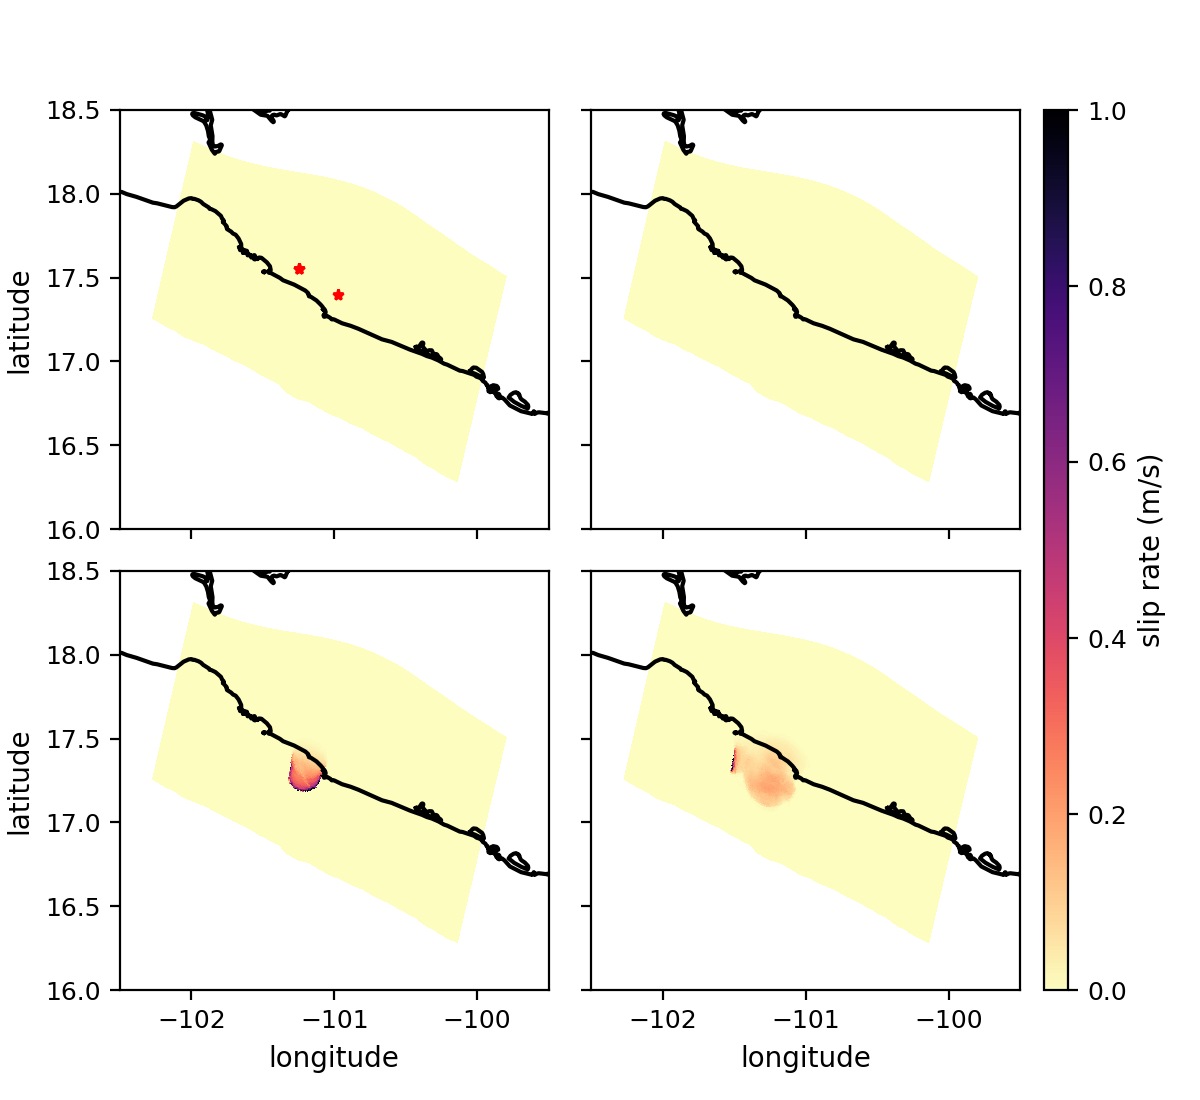

In [11]:
# plot snapshots of slip rate
fig,([ax0,ax1],[ax2,ax3]) = plt.subplots(nrows=2,ncols=2,figsize=(6,5.5))

sc = ax0.tripcolor(triang,srd2[0],cmap='magma_r',shading='flat',vmin=0,vmax=1.)
#cl = fig.colorbar(sc,ax=ax0)
ax0.set(xlim=(-102.5, -99.5),ylim=(16,18.5))
ax0.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
# ax0.contour(X,Y,coslp,levels=[8,16],colors='w')
ax0.xaxis.set_ticklabels([])
ax0.set_ylabel('latitude')
ax0.plot(epi[:,0],epi[:,1],'*r',markersize=4.0)

sc = ax1.tripcolor(triang,srd3[0],cmap='magma_r',shading='flat',vmin=0,vmax=1.)
#cl = fig.colorbar(sc,ax=ax1)
ax1.set(xlim=(-102.5, -99.5),ylim=(16,18.5))
ax1.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])

# ax0.contour(X,Y,coslp,levels=[8,16],colors='w')

sc = ax2.tripcolor(triang,srd4[0],cmap='magma_r',shading='flat',vmin=0.0,vmax=1.)
#cl = fig.colorbar(sc,ax=ax2)
ax2.set(xlim=(-102.5, -99.5),ylim=(16,18.5))
ax2.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
# ax0.contour(X,Y,coslp,levels=[8,16],colors='w')
ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude')

sc = ax3.tripcolor(triang,srd5[0],cmap='magma_r',shading='flat',vmin=0,vmax=1.)
#cl = fig.colorbar(sc,ax=ax3)
ax3.set(xlim=(-102.5, -99.5),ylim=(16,18.5))
ax3.plot(coast['ncst'][:,0],coast['ncst'][:,1],'-k',markersize=0.1)
# ax3.contour(X,Y,coslp,levels=[8,16],colors='w')
ax3.yaxis.set_ticklabels([])
ax3.set_xlabel('longitude')


fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.85,
                    wspace=0.1, hspace=0.1)
cb_ax = fig.add_axes([0.87, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sc, cax=cb_ax)
cbar.set_label('slip rate (m/s)')

plt.show()
outname = modelname+'-snapshots.png'
plt.savefig(outname,dpi=200,transparent=False)
